# Analysis of Yelp Open Dataset with PySpark

##### Abstract:

This project is aimed to query and analyze the Yelp Open Dataset using PySpark, Spark SQL alongside with built-in packages and functional APIs. A subset of Yelp datasets is selected to perform different analytical tasks ranging from finding the Top businesses from a specific city to performing collaborative filtering on recommender systems. The use of Graph data processing is also discussed. The goal is to explore the dataset using a wide range of tools in order to drive valuable insights and produce interesting results. 

## Table of contents
1.  Introduction
2. The dataset
3. Initialization
    1. create bucket and upload files 
    2. create dataproc cluster and launch jupyter notebook
4. Data Exploration
    1. Querying with the DataFrame API
    2. RDD and partitioning
    3. Querying with Spark SQL
5. Sentiment analysis on review data
    1. Tokenization and preprocessing
    2. Model fitting
6. Restaurants recommendations using ALS
    1. Model fitting
    2. Tuning parameters
    3. Computation times with different number of partitions
7. Graph Data processing
    1. Building the graph
    2. Breath First Search (BFS)
    3. Motif finding queries
8. Conclusion
9. References

## Introduction

### Apache Spark

Apache Spark is a fast and general-purpose cluster computing system. It provides high-level APIs in Java, Scala, Python and R, and an optimized engine that supports general execution graphs. It also supports a rich set of higher-level tools including Spark SQL for SQL and structured data processing, MLlib for machine learning, GraphX for graph processing, and Spark Streaming.[1] 

Apache Spark achieves high performance for both batch and streaming data, using a state-of-the-art DAG scheduler, a query optimizer, and a physical execution engine. [2]

*Figure 1: Logistic regression in Hadoop and Spark*
![](s1.png)
Source: https://spark.apache.org/

Spark powers a stack of libraries including SQL and DataFrames, MLlib for machine learning, GraphX, and Spark Streaming. You can combine these libraries seamlessly in the same application.
![](s2.png)
Source: https://spark.apache.org/

## Pipeline

This section introduces the concept of **ML Pipelines**. **ML Pipelines** provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines.

In machine learning, it is common to run a sequence of algorithms to process and learn from data. E.g., a Natural Language processing workflow might include several stages:

* Split each document’s text into words.
* Convert each document’s words into a numerical feature vector.
* Learn a prediction model using the feature vectors and labels.

PySpark MLlib represents such a workflow as a Pipeline, which consists of a sequence of PipelineStages (Transformers and Estimators) to be run in a specific order. 
![](ml-Pipeline.png)

Above, the top row represents a Pipeline with three stages. The first two (`Tokenizer` and `HashingTF`) are `Transformers` (blue), and the third (`LogisticRegression`) is an `Estimator` (red). The bottom row represents data flowing through the pipeline, where cylinders indicate DataFrames. The `Pipeline.fit()` method is called on the original DataFrame, which has raw text documents and labels. The `Tokenizer.transform()` method splits the raw text documents into words, adding a new column with words to the DataFrame. The `HashingTF.transform()` method converts the words column into feature vectors, adding a new column with those vectors to the DataFrame. Now, since **LogisticRegression** is an Estimator, the Pipeline first calls `LogisticRegression.fit()` to produce a LogisticRegressionModel. If the Pipeline had more Estimators, it would call the LogisticRegressionModel’s `transform()` method on the DataFrame before passing the DataFrame to the next stage.
![](ml-Pipeline.png)

In the figure above, the PipelineModel has the same number of stages as the original Pipeline, but all Estimators in the original Pipeline have become Transformers. When the PipelineModel’s transform() method is called on a test dataset, the data are passed through the fitted pipeline in order. Each stage’s `transform()` method updates the dataset and passes it to the next stage. [1]https://spark.apache.org/docs/latest/ml-pipeline.html .


## Collaborative filtering 

One of the strategies of recommender systems is collaborative filtering, which analyzes relationships between users and interdependencies among products[4]. The standard approach to matrix factorization based collaborative filtering treats the entries in the user-item matrix as explicit preferences given by the user to the item, for example, users giving ratings to movies.

It is common in many real-world use cases to only have access to implicit feedback [5]. spark.ml currently supports model-based collaborative filtering, in which users and products are described by a small set of latent factors that can be used to predict missing entries. `spark.ml` uses the alternating least squares (ALS) algorithm to learn these latent factors. Alternating Least Square (ALS) with `spark.ml`
is a matrix factorization algorithm and it runs itself in a parallel fashion.  ALS perfoms well in solving scalability and sparseness of the Ratings data, and it’s simple and scales well to very large datasets. ALS runs its gradient descent in parallel across multiple partitions of the underlying training data from a cluster of machines.

In section 6, an ALS example will be given to demonstrate the use in Spark.

## GraphX 

GraphX, built on top of Apache Spark, is an embedded graph processing framework and distributed dataflow system. Graph processing systems can naturally express and efficiently execute iterative graph algorithms like PageRank and cummunity detection on graphs with billions of vertices and edges, which typically outperform distributed dataflow frameworks like Hadoop MapReduce by orders of magnitude.[6]

*Figure 2: GraphX is a thin layer on top of the Spark general-purpose dataflow framework*
![](s3.png)
Source: [6]

The GraphX API enables the coposition of graphs with unstructured and tabular data and allows the same physical data to be viewed both as a graph and as collections without data movement or duplication. Not only does GraphX support existing graph-parallel abstractions and a wide range of iterative graph algorithms, it enables the composition of graphs and collections, freeing the user to adopt the most natural view without concern for data movement or duplication. 

*Figure 3: Distributed Graph Representation*
![](s4.png)
Source: [6]

**GraphFrames** is a package for Apache Spark that provides DataFrame-based graphs. It provides high-level APIs in Java, Python, and Scala. It aims to provide both the functionality of GraphX and extended functionality taking advantage of Spark DataFrames.[7]

In section 7, the use of GraphFrames will be demonstrated.

## The Yelp Open Dataset

![](yelp.png)

The [Yelp Open Dataset](https://www.yelp.com/dataset) is a subset of businesses, reviews, and user data for use in personal, educational, and academic purposes collected by Yelp. The datast contains information about 8021,122 reviews, 209,393 businesses from 10 metropolitan areas. As well as over 1.4 million business attributes like hours, parking, availability. 

The dataset includes User (registered members of Yelp), Business (including Category of each Business), Review written by User on Business, Tip given by User for general comment on Business, and others. It contains 6 individual JSON files. See [Documentation](https://www.yelp.com/dataset/documentation/main) for details.

This project focuses on **business**, **user** and **review**. 
* `business.json` includes `business_id`, `name`, `categories`, `stars`(float, star rating, rounded to half-stars) and information about business locations. 
* `user.json` includes `user_id`, `name`, `friends` and information on votes as well as the number of reviews each individual user has written. 
* `review.json` contains `user_id`, `business_id`, `stars` and full `text` of the review. Of course, each review also has a `review_id` associated with it. 

Each table extracted from individual file could be used to find information about businesses, users and reviews. By using `JOIN` operations in **spark SQL**, the three tables are combined in various ways to perform data analytics tasks in the following sections. 

The other 3 files are: `checkin.json` (checkins on a business, includes `business_id` and `date`), `tip.json` (quick suggestions written by a user on a business, shorter than review) and `photo.json` (photo data including the caption and classification, one of "food", "drink", "menu", "inside" or "outside"). 

## Initialization

Instead of running PySpark on my local machine. I will set up a remote cluster using the Google Cloud Platform. Similar functionality is also available through other Infrastructure-as-a-Service providers, such as Amazon Web Services and Microsoft Azure.

GCP can be accessed via the Google Cloud Console and the [Google Cloud SDK](https://cloud.google.com/sdk). Google Cloud SDK (Software Development Kit) is a command line tool that allows you to manage resources and services hosted on GCP. After Google Cloud SDK is [installed](https://cloud.google.com/sdk/install) and set up for macOS. One can interact with it through terminal. 

In order to upload and store files on GCP. We first need to create a bucket. A bucket is the GCP-equivalent of a directory or folder on a local computer. A bucket named yf-bucket could be created by typing the following command in terminal: 

`gsutil mb gs://yf-bucket/`

Next, 3 json files could be uploaded by the following command:

`gsutil cp \Users\Desktop\ST446project\xxx.json gs://yf-bucket`

Here `xxx` is the name of the file. 

One can also upload files by navigating to `GCP console -> storage -> bucket -> upload files`

In order to run PySpark jobs in the cloud, the next step is to set up a Dataproc cluster. Cloud Dataproc is a service for running Apache Spark and Apache Hadoop clusters and easily integrates with other GCP services (see [Dataproc documentation](https://cloud.google.com/dataproc/docs/)).

I have used the following command to create a cluster that allows us to run jupyter notebook on the cloud. Note that one needs to include relevant packages in the initialization in order to use the libraries. The cluster is located in the zone "europe-west2-a", with one standard master node and two worker nodes.
```
gcloud dataproc clusters create yf-cluster --project coco22 --bucket yf-bucket\
  --properties=^#^spark:spark.jars.packages=graphframes:graphframes:0.5.0-spark2.1-s_2.11,com.databricks:spark-xml_2.11:0.4.1 \
  --subnet default --zone europe-west2-a --master-machine-type n1-standard-4 --master-boot-disk-size 500 --num-workers 2 --worker-machine-type n1-standard-4 --worker-boot-disk-size 500 --image-version 1.3-deb9 \
  --initialization-actions 'gs://dataproc-initialization-actions/jupyter/jupyter.sh','gs://dataproc-initialization-actions/python/pip-install.sh','gs://dataproc-initialization-actions/zookeeper/zookeeper.sh','gs://dataproc-initialization-actions/kafka/kafka.sh' \
  --metadata 'PIP_PACKAGES=sklearn nltk pandas graphframes'
```

The following also works:
```
REGION=europe-west2-a
CLUSTERNAME=yf-cluster
PROJECT=coco22
BUCKET=yf-bucket
```

```
gcloud beta dataproc clusters create ${CLUSTERNAME} --project ${PROJECT} \
    --bucket ${BUCKET} --region ${REGION} \
    --image-version=preview \
    --optional-components=ANACONDA,JUPYTER \
    --enable-component-gateway \
    --initialization-actions \
    gs://goog-dataproc-initialization-actions-${REGION}/python/pip-install.sh,gs://${BUCKET}/my-actions.sh \
    --metadata 'PIP_PACKAGES=sklearn nltk pandas numpy'
```
Now that the cluster is up and running, we can remotely access it using a Secure Shell (SSH). In terminal, copy in the following command to create an SSH tunnel using local port 1080
```
gcloud compute ssh yf-cluster-m \
  --project=coco22 \
  --zone=europe-west2-b -- -D 1080 -N
```
Keep the first terminal window running and *open a seperate terminal window* in order to run Chrome and connect through the proxy
```
"/Applications/Google Chrome.app/Contents/MacOS/Google Chrome" \
  --proxy-server="socks5://localhost:1080" \
  --user-data-dir="/tmp/yf-cluster-m" http://yf-cluster-m:8123
```
Note here the pot number needs to be modified to 8123. Once the page is opened, one can upload jupyternote book from local machine into the cluster and access the file from there. In order to use PySpark, we can change the kernal to PySpark in the menu bar at the top of the file.

### Importing libraries

In [1]:
#import statements
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as psf
from pyspark.sql.functions import udf

In [2]:
from pyspark.sql import functions as f

In [4]:
import pandas as pd
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import split,explode

In [5]:
# linear regression to estimate rating.
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
from pyspark.sql import Window
from pyspark.ml.evaluation import RegressionEvaluator

import matplotlib.pyplot as plt
# from pyspark.sql.functions import rowNumber

## Data Exploration 

### Reading in JSON files

`spark.read.json()` method is provided by Spark API, it allows us to read JSON files into DataFrames. Since our notebook is running on the cloud, we need to specify our file paths in the GCP bucket.

In [88]:
#specifying the path for business file
b_name = 'gs://yf-bucket/yelp_academic_dataset_business.json'
#reading in business file
business = spark.read.json(b_name)

In [12]:
#specifying the path for user file
u_name = 'gs://yf-bucket/yelp_academic_dataset_user.json'
#reading in user file
user = spark.read.json(u_name)

In [14]:
#specifying the path for review file
r_name = 'gs://yf-bucket/yelp_academic_dataset_review.json'
#reading in review file
review = spark.read.json(r_name)

### Inferring the Schema Using Reflection

Spark can infer the schema using *reflection*; i.e. automatically determine the schema of the data based on sampling the data. 

Let's have a look at the schema of bussiness.json.

In [2]:
# Visualize the inferred schema
business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

The schema is infered correctly. It contains information about column names, data types and attributes. One can also programmatically apply the schema by using `StructureType()`. But we do not need to do this for yelp dataset.

### Querying with the DataFrame API

In [4]:
#show top five rows of business DataFrame
business.show(5)

+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|           city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|     10913 Bailey Rd|[,,,,,,, True,, T...|f9NumwFMBDn751xgF...|Active Life, Gun/...|      Cornelius|[11:0-20:0, 10:0-...|      1|35.4627242| -80.8526119|The Range At Lake...|      28031|          36|  3.5|   NC|
|8880 E Via Linda,...|[,,,,,,,,,,, True...|Yzvjg0SayhoZgCljU...|Health & Medical,...|     Scottsdale|                null|      1|33.5694041|-111.89

#### Create temporary table for SQL querying

Before querying, let's register the DataFrame as a table using `createOrReplaceTempView()`. This function creates a temporary table that can be queried using Spark SQL.

In [8]:
#creating a temorary table 
business.createOrReplaceTempView("business")

Counting the number of distinct rows in the table

In [13]:
business.distinct().count()

209393

### Querying with Spark SQL

The same query could also be written using Spark SQL - a SQL dialect that is compatible with the Hive Query Language (or HiveQL).

In [15]:
# Number of reviews (count of rows)
spark.sql('SELECT COUNT(*) AS business_count FROM business').show()

+--------------+
|business_count|
+--------------+
|        209393|
+--------------+



In order to extract useful information from the business table, a few columns are selected to generate a subset of the orginal DataFrame. 

In [9]:
# Reduce DataFrame to include only relevant variables
b_df = spark.sql('SELECT business_id, \ 
name, categories, state, city, review_count, stars FROM business')
b_df.show(5)

+--------------------+--------------------+--------------------+-----+---------------+------------+-----+
|         business_id|                name|          categories|state|           city|review_count|stars|
+--------------------+--------------------+--------------------+-----+---------------+------------+-----+
|f9NumwFMBDn751xgF...|The Range At Lake...|Active Life, Gun/...|   NC|      Cornelius|          36|  3.5|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|Health & Medical,...|   AZ|     Scottsdale|           4|  5.0|
|XNoUzKckATkOD1hP6...|             Felinus|Pets, Pet Service...|   QC|       Montreal|           5|  5.0|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|Hardware Stores, ...|   NV|North Las Vegas|           3|  2.5|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|Home Services, Pl...|   AZ|           Mesa|          26|  4.5|
+--------------------+--------------------+--------------------+-----+---------------+------------+-----+
only showing top 5 rows



#### A1. Business distribution by cities

To find cities with the most businesses, we can use `SELECT`, `COUNT(*)`, then `GROUP BY` cities, and `ORDER BY` the number of counts for each city. In order to get the top 10 cities in descending order, `DESC` could be used, then we `LIMIT` the result to 10.

In [18]:
b_df.createOrReplaceTempView("b_df")

#top 10 cities with the largest number of businesses
#count cities then order by descending order, and show the top 10 
spark.sql('SELECT city, COUNT(*) as \ 
total_businesses FROM b_df GROUP BY \ 
city ORDER BY COUNT(*) DESC LIMIT 10').show()

+----------+----------------+
|      city|total_businesses|
+----------+----------------+
| Las Vegas|           31631|
|   Toronto|           20366|
|   Phoenix|           20171|
| Charlotte|           10422|
|Scottsdale|            9342|
|   Calgary|            8377|
|Pittsburgh|            7630|
|  Montréal|            6979|
|      Mesa|            6577|
| Henderson|            5272|
+----------+----------------+



As a result, we can see that Las Vegas, Toronto and Phoenix has the most businesses signed up to yelp compared to other cities.

#### A2. Statistics on stars rating and review counts

Spark's DataFrame API offers `describe()` method to summarize descriptive statistics, which produces the count, mean, standard deviation, minimum and maxium for each variable specified.

In [27]:
b_df.describe('stars', 'review_count').show()

+-------+------------------+-----------------+
|summary|             stars|     review_count|
+-------+------------------+-----------------+
|  count|            209393|           209393|
|   mean|3.5380552358483808|36.93750507419064|
| stddev|1.0235430346225847|123.3435968392906|
|    min|               1.0|                3|
|    max|               5.0|            10129|
+-------+------------------+-----------------+



The table tells us that the mean stars business receive on Yelp is 3.5 and there's a wide range of reviews received by different businesses. The business least reviews has only 3 review counts. 

#### A3. Star rating distribution

By using the same techniques as before, one can obtain the counts of different ratings. 

In [25]:
#count number of business with different star ratings
b_stars = spark.sql('SELECT stars, COUNT(*) as \ 
count FROM b_df GROUP BY stars ORDER BY stars DESC')

# Convert Spark DataFrame to Pandas DataFrame
b_stars_pd = b_stars.toPandas()
b_stars_pd

,stars,count
0,5.0,27080
1,4.5,29940
2,4.0,39199
3,3.5,38079
4,3.0,28634
5,2.5,21435
6,2.0,13124
7,1.5,6004
8,1.0,5898


Result histogram

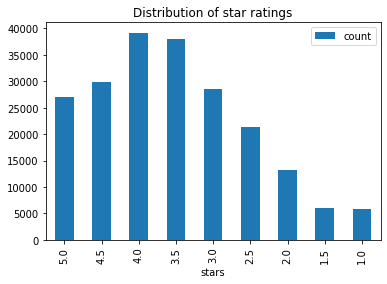

In [26]:
%matplotlib inline

# Set the DF's index to year and sort DF by year
b_stars_pd = b_stars_pd.set_index('stars')
b_stars_pd.plot.bar(title = 'Distribution of star ratings')

The ratings are slightly skewed meaning that users tend to give positive reviews.

#### A4. Top categories with the largest number of businesses

now we want to investigate into the number of business within each categories, to do this, first we need to select the categories and business id column from the table.

In [31]:
# Reduce DataFrame to include only relevant variables
bID_cat = spark.sql('SELECT business_id, categories FROM b_df')
#bID_cat.createOrReplaceTempView("bID_cat")
bID_cat.show(5)

+--------------------+--------------------+
|         business_id|          categories|
+--------------------+--------------------+
|f9NumwFMBDn751xgF...|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|Health & Medical,...|
|XNoUzKckATkOD1hP6...|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|Home Services, Pl...|
+--------------------+--------------------+
only showing top 5 rows



Here some businesses might belong to more than one categories, what we want to do here is to transform the categories column such that each row of cateogries only contain one category.

We do this by first creating an **RDD**, which is a *schema-less* data structure. The function `.rdd` transform a table to a RDD. `.take(num)` returns the first `num` rows as a **list** of Row. [3]

In [109]:
#creating a rdd
bID_cat_rdd = bID_cat.rdd

#show the first two rows. 
bID_cat_rdd.take(2)

[Row(business_id='f9NumwFMBDn751xgFiRbNA', categories='Active Life, Gun/Rifle Ranges, Guns & Ammo, Shopping'),
 Row(business_id='Yzvjg0SayhoZgCljUJRF9Q', categories='Health & Medical, Fitness & Instruction, Yoga, Active Life, Pilates')]

We have now transformed the dataframe into an RDD. Next let's strip the second element of each row.
To do this, I have used a helper function that takes in lines of words and split by comma. As different categoreis are seperated by comma followed by a space in the original dataframe.

In [114]:
def extractInformation(row):
    import re
    import numpy as np
    
    words = list(row.split(", ")) # split the line into categories by comma
    return words
b2 = bID_cat_rdd.map(lambda row:(row[0], extractInformation(row[1])))
b2.take(2)

[('f9NumwFMBDn751xgFiRbNA',
  ['Active Life', 'Gun/Rifle Ranges', 'Guns & Ammo', 'Shopping']),
 ('Yzvjg0SayhoZgCljUJRF9Q',
  ['Health & Medical',
   'Fitness & Instruction',
   'Yoga',
   'Active Life',
   'Pilates'])]

Then **function** `.flatMapValues()` is used so that each row is split into multiple rows with different category and business pair.

In [115]:
def f(x): 
    return x
b3 = b2.flatMapValues(f)
b3.take(5)

[('f9NumwFMBDn751xgFiRbNA', 'Active Life'),
 ('f9NumwFMBDn751xgFiRbNA', 'Gun/Rifle Ranges'),
 ('f9NumwFMBDn751xgFiRbNA', 'Guns & Ammo'),
 ('f9NumwFMBDn751xgFiRbNA', 'Shopping'),
 ('Yzvjg0SayhoZgCljUJRF9Q', 'Health & Medical')]

#### Improving computational speed by repartitioning

In PySpark, the `.getNumPartitions()` allows us to check the number of partitions. One can repartition RDD into different number of partitions in order to find the number of partitions that gives the optimal speed.

In [185]:
#checking the number of partitions
b2.getNumPartitions()

2

In [189]:
import time #to calculate computing speed
from numpy import sqrt, array, sin
times = []

for npart in range(25, 0, -1):
    b2rdd = b2.repartition(npart) #repartioning
    print("Number of partitions: {}".format(b2rdd.getNumPartitions()))
    t0 = time.time()
    a0 = b2rdd.flatMapValues(f)
    dt = time.time() - t0 #computing time
    print("time: ",dt)
    times = times + [dt]

Number of partitions: 25
time:  0.0007045269012451172
Number of partitions: 24
time:  0.0006229877471923828
Number of partitions: 23
time:  0.0006096363067626953
Number of partitions: 22
time:  0.0006585121154785156
Number of partitions: 21
time:  0.0006775856018066406
Number of partitions: 20
time:  0.0005283355712890625
Number of partitions: 19
time:  0.0006749629974365234
Number of partitions: 18
time:  0.00058746337890625
Number of partitions: 17
time:  0.0006251335144042969
Number of partitions: 16
time:  0.0005633831024169922
Number of partitions: 15
time:  0.0006899833679199219
Number of partitions: 14
time:  0.0006093978881835938
Number of partitions: 13
time:  0.0007300376892089844
Number of partitions: 12
time:  0.0005717277526855469
Number of partitions: 11
time:  0.0006422996520996094
Number of partitions: 10
time:  0.0007464885711669922
Number of partitions: 9
time:  0.0006890296936035156
Number of partitions: 8
time:  0.0004870891571044922
Number of partitions: 7
time:  0

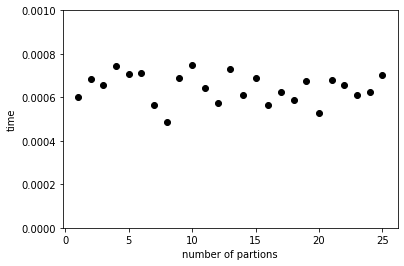

In [191]:
#plotting the results

times = array(times)
from matplotlib import pyplot as plt
plt.plot(range(25,0,-1),times,'ko')
plt.xlabel("number of partions")
plt.ylabel("time")
plt.ylim([0,0.001])
plt.show();

As a result, 7 and 20 seems to be the desired number of partitions to perform this simple task. Note that too little or too many partitions does not improve the efficiency.

#### number of businesses in each category

In [168]:
business_cat_df = sqlContext.createDataFrame(
    b3, ['business_id', 'category'])
business_cat_df.show(5)

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows



`explode` and `split` are SQL functions, both operate on SQL `Column`. `split` takes a Java regular expression as a second argument. To split each row in **category**, we can simply do the following:

In [10]:
#select category column
category = business.select('categories')

#split each row of category then make into multiple rows
category1 = category.select(
    explode(split('categories', ', ')).alias('category'))
#count different numbers of businesses in categories
group_category = category1.groupBy('category').count()

#show the top categories with the most business
top_category = group_category.sort('count', ascending= False)
top_category.show(10, truncate=False)

+----------------+-----+
|category        |count|
+----------------+-----+
|Restaurants     |63944|
|Shopping        |34644|
|Food            |32991|
|Home Services   |22487|
|Beauty & Spas   |20520|
|Health & Medical|19227|
|Local Services  |15783|
|Automotive      |14720|
|Nightlife       |14211|
|Bars            |12400|
+----------------+-----+
only showing top 10 rows



Bar plot to visulize the result

Text(0.5, 1.0, 'Distribution of Top cateogries')

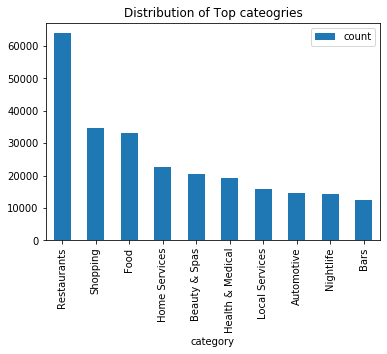

In [14]:
#plotting the result

top_category_df = top_category.toPandas()[:10]
top_category_df.plot(kind='bar',x='category',y='count')
plt.title("Distribution of Top cateogries")

As we can see, most businesses registered with Yelp fall into `Restaurants` category. 

#### B1. Users that give the most number of reviews

The user DataFrame will be used to answer this question.

In [141]:
#checking user schema 
user.printSchema()

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)



In [16]:
#creating a temporary table 
user.createOrReplaceTempView("user")

#counting the number of users
user.count()

1968703

In [230]:
top_user = spark.sql('SELECT user_id, name, \ 
review_count FROM user ORDER BY review_count DESC LIMIT 5')
top_user.show()

+--------------------+--------+------------+
|             user_id|    name|review_count|
+--------------------+--------+------------+
|8k3aO-mPeyhbR5HUu...|  Victor|       14455|
|RtGqdDBvvBCjcu5dU...|   Shila|       12772|
|hWDybu_KvYLSdEFzG...|   Bruce|       12487|
|Hi10sGSZNxQH3NLyW...|     Fox|       11112|
|P5bUL3Engv-2z6kKo...|     Kim|        9875|
|8RcEwGrFIgkt9WQ35...|  George|        7745|
|nmdkHL2JKFx55T3nq...|  Nijole|        7626|
|Xwnf20FKuikiHcSpc...| Kenneth|        6762|
|CxDOIDnH8gp9KXzpB...|Jennifer|        6633|
|HFECrzYDpgbS5EmTB...|    Eric|        5500|
+--------------------+--------+------------+



User Victor has written the most reviews.

## Sentiment analysis on reviews

NLP(Natrual Language processing) is widely used in businesses to drive valuable insights into customer preferences. This section focuses on the `text` column in the review dataset, which contains sentences of reviews left by raters. This part aims at finding the most frequently used word in the review and predict the likes based on the text. We first generate term frequencies using **TF-IDF** method, then fit a **LogisticRegression** model to predict ratings. 

First, print the schema of review dataset.

In [142]:
review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [231]:
review.createOrReplaceTempView("review")
review.count()

8021122

### Tokenization and preprocessing

Firstly, define ratings higher than 4 stars to be postive and otherwise negative. 

In [43]:
def convert_rating(rating):
    '''if review higher than 4 stars,
    class as positive, otherwise negative reviews'''
    if rating >=4:
        return 1
    else:
        return 0

`.lower()` and `.replace()` allows us to remove all punctuations in the text and convert all letters to lowercases. 

In [44]:
#remove punctuations
def lower_clean_str(x):
    punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    lowercased_str = x.lower() #convert to lower case
    for ch in punc:
        lowercased_str = lowercased_str.replace(ch, '')
    return lowercased_str

UDFs allow us to apply the function defined above to text column. Inline definitions of UDFs are supported in Spark SQL's DataFrame API. 

In [45]:
#remove punctuation and convert to lower cases
punct_remover = udf(lambda x: lower_clean_str(x))
df_word = review.select('*', punct_remover('text')).drop('text')

#RENAMING THE CLOUMN
df_word = df_word.withColumnRenamed('<lambda>(text)', 'text')

Converting ratings to a number that represents positive/negative.

In [46]:
rating_convert = udf(lambda x: convert_rating(x))

In [47]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer,StringIndexer,CountVectorizer
import pyspark.mllib.classification
from pyspark.sql.functions import udf
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
import string
import re
import nltk

In [48]:
df_NLP =df_word.select('*',rating_convert('stars'))
df_NLP = df_NLP.withColumnRenamed('<lambda>(stars)', 'isPositive')

`Tokenizer` splits words sentences into words. `StopWordsRemover` filters out words that do not carry much meaning. 

In [49]:
#tokenize words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
#remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

# Build the pipeline 
pipeline = Pipeline(stages=[tokenizer,remover])
# Fit the pipeline 
df_NLP = pipeline.fit(df_NLP).transform(df_NLP)

`HashingTF` takes sets of terms and converts those sets into fixed-length feature vectors. `HashingTF` utilizes the hashing trick. A raw feature is mapped into an index (term) by applying a hash function.

In [50]:
#Maps a sequence of terms to their term frequencies 
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

# Build the pipeline 
pipeline = Pipeline(stages=[hashingTF,idf])
# Fit the pipeline 
encodedData_hasingTF = pipeline.fit(df_NLP).transform(df_NLP)

Only a few columns are needed.

In [51]:
#drop the redundant source column
encodedData_tf = encodedData_hasingTF.select(
    'review_id','words','features','stars')

In [52]:
DF_sa =encodedData_tf.select(rating_convert('stars'),'features')
DF_sa = DF_sa.withColumnRenamed('<lambda>(stars)', 'isPositive')
DF_sa.show(3)

+----------+--------------------+
|isPositive|            features|
+----------+--------------------+
|         0|(1000,[19,37,63,7...|
|         0|(1000,[3,7,77,81,...|
|         1|(1000,[57,77,122,...|
+----------+--------------------+
only showing top 3 rows



In [53]:
#convert classification from string to integer to enable model to run
from pyspark.sql import types 
DF_sa = DF_sa.withColumn("isPositive",
                         DF_sa["isPositive"].cast('int'))

DF_sa.groupby('isPositive').count().show()

+----------+-------+
|isPositive|  count|
+----------+-------+
|         1|5259864|
|         0|2761258|
+----------+-------+



### Fitting the model

Randomly splitting the dataset into training and testing. Here we use 80% of the data to train the model then test on the remaining 20%. 

In [54]:
splits = DF_sa.randomSplit([0.8, 0.2],seed=100)
train_df_tf = splits[0]
test_df_tf = splits[1]

Fitting the LogisticRegression Model.

In [55]:
from pyspark.ml.classification import LogisticRegression

# Set parameters for Logistic Regression maxIter=10, regParam=0.01
lg_tf = LogisticRegression(maxIter=10,regParam=0.01, featuresCol = 'features', labelCol='isPositive')

# Fit the model to the data.
lgModel_tf = lg_tf.fit(train_df_tf)

# Given a dataset, predict each point's label, and show the results.
lg_pred_tf = lgModel_tf.transform(test_df_tf)

In [56]:
lg_pred_tf.show(5)

+----------+--------------------+--------------------+--------------------+----------+
|isPositive|            features|       rawPrediction|         probability|prediction|
+----------+--------------------+--------------------+--------------------+----------+
|         0|(1000,[0,1,2,3,6,...|[-6.8047786361874...|[0.00110723818277...|       1.0|
|         0|(1000,[0,1,2,3,7,...|[3.54767280447623...|[0.97201418992814...|       0.0|
|         0|(1000,[0,1,2,3,8,...|[-2.6102245192127...|[0.06848327951063...|       1.0|
|         0|(1000,[0,1,2,3,9,...|[3.05254719424794...|[0.95489236885811...|       0.0|
|         0|(1000,[0,1,2,5,7,...|[3.51179818071930...|[0.97102160541516...|       0.0|
+----------+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



Plotting the ROC curve

areaUnderROC: 0.903999831914541


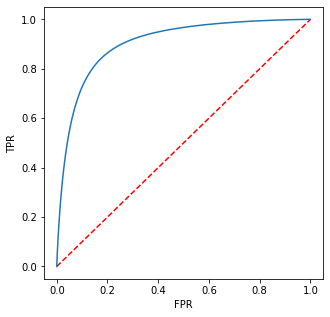

In [57]:
trainingSummary = lgModel_tf.summary
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))
#import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lgModel_tf.summary.roc.select('FPR').collect(),
         lgModel_tf.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

Instead of using `HashingTF`, one can also use `CountVectorizer` to generate a frequency vector. The size of the vector generated through `CountVectorizer` depends on the training corpus and the document whereas the one generated through `HashingTF` has fixed size. `HashingTF` suffers from potential hash collision i.e. 2 or more terms may be mapped to same index thereby becoming same after hashing. One can increase the target feature dimention in order to avoid hash collision. Due to global term to index mapping `CountVectorizer` is more computationally expensive as compared to HashingTF which utilizes the hashing trick.

## Restaurants recommendations using ALS

In this section, we demonstrate the use of ALS (alternating least squares) to find restaurant recommendations in Las Vegas for users.

The standard approach to matrix factorization-based collaborative filtering treats the entries in the user-item matrix as explicit preferences given by the user to the item. The approach used in `spark.ml` to deal with such data is taken from [cf]. Essentially instead of finding the low-rank approximations to the rating matrix R, this finds the approximations for a preference matrix P where the elements of P are 1 if r > 0 and 0 if r <= 0. The ratings then act as ‘confidence’ values related to strength of indicated user preferences rather than explicit ratings given to items.

All three datasets will be used to perform the task, therefore, different datasets need to be joined together by using `.join()` operations.

### Creating a new DataFrame

In [17]:
#change name for starts to avoid duplicates
df_business=business.withColumnRenamed("stars", "Restaurant_stars")
df_business=df_business.withColumnRenamed("name", "Restaurant_name")

#filter out businesses that are restarants
df_business=df_business.filter(psf.col('categories').
                               rlike('Restaurants'))
df_business = df_business.select('*','attributes.*','hours.*')

#dropping unwanted columns
columns_to_drop = ['address','postal_code','review_count',
                   'attributes','hours']
df_business = df_business.drop(*columns_to_drop)

Clear contents in categories column by using `regexp_replace()` which works in a similar way as the `replace()` function. 

In [18]:
df_business = df_business.withColumn('categories', 
regexp_replace(col("categories"), "(,?\ ?Restaurants,?)", ""))

df_business = df_business.withColumn('categories', 
regexp_replace(col("categories"), "( ?)", ""))

In [20]:
columns_to_drop = ['elite','useful','yelping_since',
                   'review_count','average_stars']
df_user = user.drop(*columns_to_drop)
df_user=df_user.withColumnRenamed("name", "user_name")

In [21]:
columns_to_drop = ['cool','funny','average_stars']
df_reviews = review.drop(*columns_to_drop)

Assigning an integer to user/business 

In [22]:
w = Window().orderBy('business_id')

df_business= df_business.withColumn(
    "business_id_int", psf.row_number().over(w))

w = Window().orderBy('user_id')
df_user= df_user.withColumn("user_id_int", psf.row_number().over(w))

Merging all three tables together by inner join.

In [23]:
#join three tables into one table
df = df_reviews.join(df_business,on ='business_id', how = 'inner')
df = df.join(df_user,on ='user_id', how = 'inner')

Only keeping restaurants in Las Vegas.

In [24]:
df_las = df.filter(psf.col('city')=='Las Vegas'
                  ).filter(psf.col('state')=='NV')

In [25]:
from pyspark.ml.recommendation import ALS

In [26]:
ratings = df_las.select('user_id_int','business_id_int',
                        'Restaurant_name','user_name','stars')

### Fitting the model

Setting `coldStartStrategy` parameter to “drop” in order to drop any rows in the DataFrame of predictions that contain NaN values. The evaluation metric will then be computed over the non-NaN data and will be valid

In [27]:
#splitting dataset to training and testing
train_df, test_df = ratings.randomSplit([.8,.2],seed=1)

#setting the maximum number of iterations to 10
#latent factors to 10
als = ALS(maxIter=10, regParam=0.3, userCol="user_id_int", 
          itemCol="business_id_int", ratingCol="stars",
          coldStartStrategy="drop", rank=10, nonnegative = True)

#fit and predict
model = als.fit(train_df)
predictions = model.transform(test_df)

Visualizing prediction dataset

In [28]:
predictions_df = predictions.toPandas()
predictions_df.head()

,user_id_int,business_id_int,Restaurant_name,user_name,stars,prediction
0,1815977,833,Distill - A Local Bar,Shane,5.0,3.927395
1,1328996,833,Distill - A Local Bar,Dave,4.0,3.022335
2,828272,833,Distill - A Local Bar,Cindy,5.0,2.331356
3,1812182,1580,Pho Bistro,D,5.0,4.479851
4,964027,1580,Pho Bistro,Jiaan,5.0,1.263741


Boxplots of predictions of starts from 1 to 5

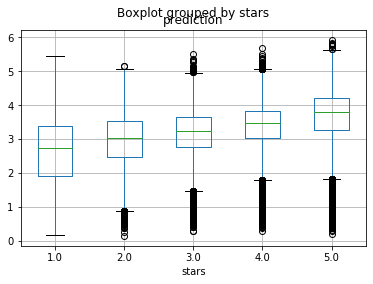

In [29]:
predictions_df.boxplot('prediction','stars')

Computing the root mean squared error. 

In [30]:
evaluator = RegressionEvaluator(metricName='rmse', labelCol='stars')
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error is " + str(rmse))

Root-mean-square error is 1.380695914984951


Generating top 10 restauarnt recommendations for top 10 users

In [31]:
# Generate top 10 restaurant recommendations for top 10 users
userRecs = model.recommendForAllUsers(10).limit(10)
userRecs_DF = (userRecs
  .select("user_id_int", explode("recommendations")
  .alias("recommendation"))
  .select("user_id_int", "recommendation.*")
)


userRecs_DF2 = userRecs_DF.join(
    df_user.select('user_id_int','user_name'), 
    on='user_id_int', how ='inner').join(
    df_business.select('business_id_int','Restaurant_name'), 
    on='business_id_int', how ='inner')

userRecs_df2 = userRecs_DF2.toPandas()

Visualizing the results for top 2 users

In [32]:
userRecs_df2.sort_values(['user_name','rating'],
                         ascending=[True,False]).head(20)

,business_id_int,user_id_int,rating,user_name,Restaurant_name
49,15411,1591,3.737341,Angela,Fernandez Hot-Dogs
48,50756,1591,3.724194,Angela,Roberta's Steakhouse
47,1259,1591,3.684286,Angela,Goat Post Tropical Grill
46,59279,1591,3.647804,Angela,Bambini's Pizzeria & Italian Restaurant
45,34663,1591,3.625922,Angela,Sushi House Manda
44,31005,1591,3.597710,Angela,New York Street Dogs
43,3590,1591,3.595601,Angela,Steve-O's New York Pizza
42,18549,1591,3.589081,Angela,Las Delicias de México
41,51955,1591,3.537445,Angela,Buster's Dawg House
40,41497,1591,3.536797,Angela,Fusion Grille


Generating top 10 user recommendations for top 10 restaurant

In [33]:
# Generate top 10 user recommendations for top 10 restaurant
restaurantRecs = model.recommendForAllItems(10).limit(10)
restaurantRecs_DF = (restaurantRecs
  .select("business_id_int", explode("recommendations")
  .alias("recommendation"))
  .select("business_id_int", "recommendation.*")
)


restaurantRecs_DF2 = restaurantRecs_DF.join(
    df_user.select('user_id_int','user_name'), 
    on='user_id_int', how ='inner').join(
    df_business.select('business_id_int','Restaurant_name'), 
    on='business_id_int', how ='inner')

restaurantRecs_df2 = restaurantRecs_DF2.toPandas()

In [34]:
restaurantRecs_df2.sort_values(['Restaurant_name','rating'],
                               ascending=[True,False]).head(20)

,business_id_int,user_id_int,rating,user_name,Restaurant_name
33,44822,815762,6.712960,Erika,Bocho Sushi
1,44822,87161,6.696429,Robbyn,Bocho Sushi
89,44822,1842156,6.502682,Dayane,Bocho Sushi
20,44822,438921,6.318418,Milissa,Bocho Sushi
76,44822,1731950,6.318418,Jessica,Bocho Sushi
36,44822,851805,6.196334,Tim,Bocho Sushi
42,44822,927153,6.146085,Taylor,Bocho Sushi
98,44822,1924741,6.002655,Bruce,Bocho Sushi
61,44822,1371265,5.975948,Emily,Bocho Sushi
5,44822,108913,5.953279,Quest,Bocho Sushi


### Check the number of partitions used 

Spark also supports pulling data sets into a cluster-wide in-memory cache.

In [36]:
# split the data to training and test parts
(training, test) = ratings.randomSplit([0.8, 0.2], seed=10)
training.cache()
test.cache()
print('Number of partitions: ', training.rdd.getNumPartitions())
print('Number of workers:', sc._conf.get('spark.executor.instances'))

Number of partitions:  200
Number of workers: 2


### Tuning parameters to find the optimal model

Here we use a function to compute RMSE for different combinations of parameters. 

In [40]:
def tune_ALS(train_data, validation_data, maxIter, regParams, ranks):
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in regParams:
            # get ALS model
#             als = ALS().setMaxIter(maxIter).setRank(rank).setRegParam(reg)
            als = ALS(maxIter=maxIter, regParam=reg, userCol="user_id_int", 
                      itemCol="business_id_int", ratingCol="stars",
                      coldStartStrategy="drop", nonnegative = True, rank = rank)
            # train ALS model
            model = als.fit(train_data)
            # evaluate the model by computing the RMSE on the validation data
            predictions = model.transform(validation_data)
            evaluator = RegressionEvaluator(metricName="rmse",
                                            labelCol="stars",
                                            predictionCol="prediction")
            rmse = evaluator.evaluate(predictions)
            print('{} latent factors and regularization = {}: '
                  'validation RMSE is {}'.format(rank, reg, rmse))
            if rmse < min_error:
                min_error = rmse
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and '
          'regularization = {}'.format(best_rank, best_regularization))
    return best_model

Compare the results using 3 different regularization parameters and 3 different latent factors.

In [42]:
best_model = tune_ALS(train_df, test_df, 
maxIter = 10, regParams=[0.01, 0.3,0.8], ranks=[5, 10, 20])

5 latent factors and regularization = 0.01: validation RMSE is 1.7250521442604057
5 latent factors and regularization = 0.3: validation RMSE is 1.3749662326586523
5 latent factors and regularization = 0.8: validation RMSE is 1.493523180256213
10 latent factors and regularization = 0.01: validation RMSE is 1.8570543096614813
10 latent factors and regularization = 0.3: validation RMSE is 1.3806959151683817
10 latent factors and regularization = 0.8: validation RMSE is 1.4936261586806128
20 latent factors and regularization = 0.01: validation RMSE is 1.9089116491338207
20 latent factors and regularization = 0.3: validation RMSE is 1.3815536747928088
20 latent factors and regularization = 0.8: validation RMSE is 1.4937304764851418

The best model has 5 latent factors and regularization = 0.3


### Checking the computation speed of using different partitions numbers

In [39]:
import time
from numpy import sqrt, array, sin
times = []

for npart in range(200, 10, -60):
    (training, test) = ratings.randomSplit([0.8, 0.2], seed=10)
    training = training.repartition(npart)
    print("Number of partitions: {}".format(training.rdd.getNumPartitions()))
    t0 = time.time()
    als = ALS(maxIter=10, regParam=0.3, userCol="user_id_int", itemCol="business_id_int", ratingCol="stars",
          coldStartStrategy="drop", rank=10, nonnegative = True)
#fit and predict
    model = als.fit(training)
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='stars')
    rmse = evaluator.evaluate(predictions)
    #print("Root-mean-square error: " + rmse)
    dt = time.time() - t0
    print("time: ",dt)
    times = times + [dt]

Number of partitions: 200
time:  49.48891615867615
Number of partitions: 140
time:  47.16059136390686
Number of partitions: 80
time:  45.37790870666504
Number of partitions: 20
time:  43.57287240028381


## Graph analysis

This section explores the use of GraphFrames package for Apache Spark. 

### Building the graph

In [7]:
import graphframes
from graphframes import *

In [39]:
business = business.dropna()
user = user.dropna()
review = review.dropna()

A graph contains vertices and edges. Vertices are nodes in the graph representing objects, edges are relationships that links between vertices. For Yelp, a typical use of vertices would be users and companies. 

Vertices contain the following information in the form of columns: `id`, `name`, `type` and `city`.

In [102]:
#adding type of businesses as company 
b_V = business.withColumn( "type", f.lit("company") ) \
.select( f.col("business_id").alias("id"),
"name", "type", "city")
b_V.show(5)

+--------------------+--------------------+-------+---------------+
|                  id|                name|   type|           city|
+--------------------+--------------------+-------+---------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|company|      Cornelius|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|company|     Scottsdale|
|XNoUzKckATkOD1hP6...|             Felinus|company|       Montreal|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|company|North Las Vegas|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|company|           Mesa|
+--------------------+--------------------+-------+---------------+
only showing top 5 rows



In [103]:
u_V = user.withColumn("type", f.lit("user")) \
.withColumn("city", f.lit("")) \
.select( f.col("user_id").alias("id"),
"name", "type", "city")

u_V.show(5)

+--------------------+--------+----+----+
|                  id|    name|type|city|
+--------------------+--------+----+----+
|ntlvfPzc8eglqvk92...|  Rafael|user|    |
|FOBRPlBHa3WPHFB5q...|Michelle|user|    |
|zZUnPeh2hEp0WydbA...|  Martin|user|    |
|QaELAmRcDc5TfJEyl...|    John|user|    |
|xvu8G900tezTzbbfq...|    Anne|user|    |
+--------------------+--------+----+----+
only showing top 5 rows



Set the begin and end edge columns to **src** and **dst** for the edges DataFrame. **src** are users and **dsc** are businesses. The columns in the edge DataFrame are `src`, `dst`, `relationship`, `stars`. (user reviewed company)

In [104]:
r_E = review.withColumn("relationship", f.lit("reviewed")) \
.select( f.col("user_id").alias("src"),
f.col("business_id").alias("dst"),
"relationship", "stars")

r_E.show(5)

+--------------------+--------------------+------------+-----+
|                 src|                 dst|relationship|stars|
+--------------------+--------------------+------------+-----+
|OwjRMXRC0KyPrIlcj...|-MhfebM0QIsKt87iD...|    reviewed|  2.0|
|nIJD_7ZXHq-FX8byP...|lbrU8StCq3yDfr-QM...|    reviewed|  1.0|
|V34qejxNsCbcgD8C0...|HQl28KMwrEKHqhFrr...|    reviewed|  5.0|
|ofKDkJKXSKZXu5xJN...|5JxlZaqCnk1MnbgRi...|    reviewed|  1.0|
|UgMW8bLE0QMJDCkQ1...|IS4cv902ykd8wj1TR...|    reviewed|  4.0|
+--------------------+--------------------+------------+-----+
only showing top 5 rows



Another edge DataFrame is added representing relationships between users. If 2 users are friends then there is an edge pointing from **src** to **dst**. The stars column here is set to empty. We need this column to match the dimensions of previous DataFrames.

In [105]:
f_E = user.withColumn("relationship", f.lit("friend")) \
.withColumn("stars", f.lit("")) \
.select(f.col("user_id").alias("src"),
f.explode(f.split("friends", ", ")).alias("dst"),
"relationship", "stars")
f_E.show(5)

+--------------------+--------------------+------------+-----+
|                 src|                 dst|relationship|stars|
+--------------------+--------------------+------------+-----+
|ntlvfPzc8eglqvk92...|oeMvJh94PiGQnx_6G...|      friend|     |
|ntlvfPzc8eglqvk92...|wm1z1PaJKvHgSDRKf...|      friend|     |
|ntlvfPzc8eglqvk92...|IkRib6Xs91PPW7pon...|      friend|     |
|ntlvfPzc8eglqvk92...|A8Aq8f0-XvLBcyMk2...|      friend|     |
|ntlvfPzc8eglqvk92...|eEZM1kogR7eL4GOBZ...|      friend|     |
+--------------------+--------------------+------------+-----+
only showing top 5 rows



The GraphFrame is then created by specifying vertices and edges. `.union()` allows us to find all the vertices and edges.  

In [106]:
all_vertices = u_V.union(b_V)
all_edges = r_E.union(f_E)
g1 = GraphFrame(all_vertices, all_edges)

### Breath First Search (BFS)

**BFS** is an algorithm for searching graph data structures. It starts from the root node and explore all the neighbour nodes at the present depth prior to moving on to the nodes at the next depth level. 

BFS is used on this user-business GraphFrame to find shortest path between the user and business in Las Vegas. 

The built in function `.bfs()` performs a bfs easily by taking in vertex and edge filters, `maxPathLength` is the limit on the length of paths. For example, a restaurant recommendation for user Shobeir based on what his friends have liked or the star rating of the restaurant itself in Las vegas could be achieved by:

In [109]:
path = g1.bfs("name = 'Shobeir'", 
              "city = 'Las Vegas'", 
              edgeFilter = "stars = 5 or relationship = 'friend'", 
              maxPathLength = 4)

path.select("from.name", "e0.relationship", "to.name", "to.city").show()

+-------+------------+---------------+---------+
|   name|relationship|           name|     city|
+-------+------------+---------------+---------+
|Shobeir|      friend|Costco Gasoline|Las Vegas|
+-------+------------+---------------+---------+



### Motif finding queries

Next, we perform motif finding tasks on a subset of the original business dataframe. Businesses from 3 cities (Fairview, Burton, Bridgeville) were selected. `review_count` attribute was added to Vertices. `useful` attribute was added to Edges.

In [113]:
business.createOrReplaceTempView("business")

#filtering business from three cities
business = spark.sql("SELECT * FROM business WHERE \
business.city = 'Fairview' or business.city = 'Burton' \ 
or business.city = 'Bridgeville'")

In [62]:
#let's first create the vertex dataframe 
business_v = business.withColumn("type", f.lit("company")). \
withColumnRenamed("business_id","id").select("id","name","review_count", "type","city")
user_v = user.withColumn("type", f.lit("user")).withColumn("city", f.lit("")).withColumnRenamed("user_id","id" \
            ).select("id","name","review_count", "type", "city")

In [63]:
#edge dataframe 
review_e = review.withColumn("relationship", \
                             f.lit("reviewed")
).withColumnRenamed("user_id","src") \
.withColumnRenamed("business_id","dst") \
.select("src","dst", "stars","useful", "relationship")


friend_e = user.withColumn("useful", f.lit("")).withColumn("relationship", f.lit("friend")) \
.withColumn("stars", f.lit("")) \
.select(f.col("user_id").alias("src"), explode(split("friends", ", ")
).alias("dst"), "stars", "useful", "relationship")

In [64]:
#creating the graphframe
all_vertices = user_v.union(business_v)
all_edges = review_e.union(friend_e)
g = GraphFrame(all_vertices, all_edges)


In [65]:
g.vertices.show(10)

+--------------------+--------+------------+----+----+
|                  id|    name|review_count|type|city|
+--------------------+--------+------------+----+----+
|ntlvfPzc8eglqvk92...|  Rafael|         553|user|    |
|FOBRPlBHa3WPHFB5q...|Michelle|         564|user|    |
|zZUnPeh2hEp0WydbA...|  Martin|          60|user|    |
|QaELAmRcDc5TfJEyl...|    John|         206|user|    |
|xvu8G900tezTzbbfq...|    Anne|         485|user|    |
|z5_82komKV3mI4ASG...|   Steve|         186|user|    |
|ttumcu6hWshk_EJVW...|  Stuart|          12|user|    |
|f4_MRNHvN-yRn7EA8...|Jennifer|         822|user|    |
|UYACF30806j2mfbB5...|  Justin|          14|user|    |
|QG13XBbgHWydzThRB...|  Claire|         218|user|    |
+--------------------+--------+------------+----+----+
only showing top 10 rows



In [66]:
g.edges.show(10)

+--------------------+--------------------+-----+------+------------+
|                 src|                 dst|stars|useful|relationship|
+--------------------+--------------------+-----+------+------------+
|OwjRMXRC0KyPrIlcj...|-MhfebM0QIsKt87iD...|  2.0|     5|    reviewed|
|nIJD_7ZXHq-FX8byP...|lbrU8StCq3yDfr-QM...|  1.0|     1|    reviewed|
|V34qejxNsCbcgD8C0...|HQl28KMwrEKHqhFrr...|  5.0|     1|    reviewed|
|ofKDkJKXSKZXu5xJN...|5JxlZaqCnk1MnbgRi...|  1.0|     0|    reviewed|
|UgMW8bLE0QMJDCkQ1...|IS4cv902ykd8wj1TR...|  4.0|     0|    reviewed|
|5vD2kmE25YBrbayKh...|nlxHRv1zXGT0c0K51...|  5.0|     2|    reviewed|
|aq_ZxGHiri48TUXJl...|Pthe4qk5xh4n-ef-9...|  5.0|     1|    reviewed|
|dsd-KNYKMpx6ma_sR...|FNCJpSn0tL9iqoY3J...|  5.0|     0|    reviewed|
|P6apihD4ASf1vpPxH...|e_BiI4ej1CW1F0EyV...|  5.0|     0|    reviewed|
|jOERvhmK6_lo_XGUB...|Ws8V970-mQt2X9CwC...|  4.0|     3|    reviewed|
+--------------------+--------------------+-----+------+------------+
only showing top 10 

#### Vertex degrees

For a directed graph G=(V(G),E(G)) and a vertex x1∈V(G), the `outDegree` of x1 refers to the number of arcs incident from x1. That is, the number of arcs directed away from the vertex x1. The `inDegree` of x1 refers to the number of arcs incident to x1. That is, the number of arcs directed towards the vertex x1. `degree` of a vertex of a graph is the number of edges that are incident to the vertex. 

In our graph, degree represents the number of reviews and relationship a user holds.

In [67]:
g.degrees.sort("Degree", ascending=False).show(5)

+--------------------+------+
|                  id|degree|
+--------------------+------+
|                None|834851|
|qVc8ODYU5SZjKXVBg...| 19183|
|iLjMdZi0Tm7DQxX1C...| 16508|
|ZIOCmdFaMIF56FR-n...| 15838|
|Oi1qbcz2m2SnwUezt...| 14040|
+--------------------+------+
only showing top 5 rows



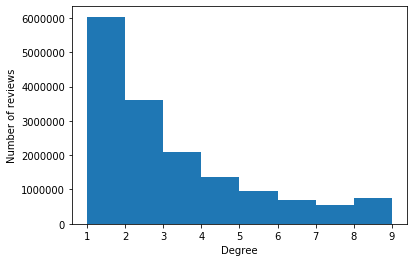

In [46]:
plt.hist(g.degrees.select("degree").rdd.flatMap(lambda x: x).collect(), bins=range(1,10));
plt.ylabel('Number of reviews')
plt.xlabel('Degree');

#### Find how many users have given 5 star review to businesses from two different cities

* A pattern that contains two edges, user has reviewed business1 and user has reviewed business2
* User reviewed a business: `(u)-[r1]->(b1)`
* Filter the returned edge sets (using `results.filter()`) to specify that businesses (b1 and b2) should be from different cities and both of the review edges should be 5 star reviews.
* Filtering by review stars: `r1.stars = 5`
* Filtering by cities being different: `b1.city != b2.city`

The result shows that 31555 users have given 5 stars review to businesses from 2 different cities. 

In [68]:
task1 = g.find("(u)-[r1]->(b1); (u)-[r2]->(b2)").filter("r1.stars = 5 and b1.city != b2.city")

In [69]:
task1.count()

31555

#### Top 5 businesses which have received the most conflicted reviews from pairs of friends

Definition of Conflicting reviews from a pair of friends: Two users who are friends gave the opposite review score to the same business. 
We use stars threshold 2 & 4 to represent opposite reviews. i.e. A pair of friends rated below 2 and above 4 stars respectively.

A motif query for finding all possible edge sets where:
Vertices `u1` and `u2` (*users*) and connected through two different (*review*) Edges to the same Vertex `b` (*company*).
`u1` and `u2` are connected through a (*friend*) Edge.

Filter the results by:
* `b` is of type **company**
* Two review scores must be conflicting
* Edge between users `u1` and `u2` should be of type friend
* `groupby` the `Business vertex`, compute count, `orderby` **count** in **descending** manner and **limit** results to **5**.

In [70]:
#specifying the path query
task2 = g.find("(u1)-[r1]->(b); (u2)-[r2]->(b); (u1)-[f]->(u2)")

#filter type by company, one of the rating must be below 2 stars
#while the other bigger than 4
task2_filter  = task2.filter("b.type = 'company'and r1.stars <= 2 and \
r2.stars>=4 and f.relationship = 'friend'")

In [72]:
#Group the found paths by the Business vertex, 
#compute count, order by count in descending manner 
#and limit results to 5.
result = task2_filter.groupBy("b.name").count().orderBy(desc("count")).limit(5)
result.show()

+--------------------+-----+
|                name|count|
+--------------------+-----+
|Walnut Grill - Br...|   15|
|Bubba's Gourmet B...|   15|
|             Topgolf|   11|
|     Texas Roadhouse|    8|
|        Blazin Bills|    7|
+--------------------+-----+



## Conclusion

Yelp dataset is rich and allows for different kinds of data analytics. By utilizing the use of PySpark and its built-in functional APIs, one is able to perform a wide range of tasks. Spark SQL allows for different types of queries, packages such as MLlib supports scalabe machine learning methods, motif finding using Graphframe enables efficient processing in relational data structures. This project focused on the wide range of functionalities that PySpark has to offer as well as the implementation of distributed computing in its built in packages. 

## References

[1] Apache Spark documentation. https://spark.apache.org/docs/latest/

[2] Apache Spark Project https://spark.apache.org/

[3] PySpark documentation https://spark.apache.org/docs/1.3.1/api/python/pyspark.sql.html

https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1

[4] Koren, Yehuda, Robert Bell, and Chris Volinsky. "Matrix factorization techniques for recommender systems." Computer 42.8 (2009): 30-37.

[5] Y. Hu, Y. Koren and C. Volinsky, "Collaborative Filtering for Implicit Feedback Datasets," 2008 Eighth IEEE International Conference on Data Mining, Pisa, 2008, pp. 263-272.

[6] Gonzalez, Joseph E., et al. "Graphx: Graph processing in a distributed dataflow framework." 11th {USENIX} Symposium on Operating Systems Design and Implementation ({OSDI} 14). 2014.

[7] GraphFrames documentation https://docs.databricks.com/spark/latest/graph-analysis/graphframes/user-guide-python.html

[8] Singh, Ruchi, et al. "Applications of Machine Learning Models on Yelp Data." Asia Pacific Journal of Information Systems 29.1 (2019): 117-143.

[9] Yu, Boya, et al. "Identifying Restaurant Features via Sentiment Analysis on Yelp Reviews." arXiv preprint arXiv:1709.08698 (2017).